# <font color='darkblue'>Setup</font> 

## <font color='orange'>Packages</font> 

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter
import datetime as dt
from scipy.interpolate import griddata

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Timing Processes and Progress
import time
from tqdm import tqdm

# make sure the figures plot inline rather than at the end
%matplotlib inline

## <font color='orange'>Functions</font> 

In [2]:
# filtering a 2D matrix ---------------------------------------------------------------#
def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# put coastlines on map and set xy limits ---------------------------------------------#
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

# mask coastlines ---------------------------------------------------------------------#
def mask_coast(c_lon,c_lat,bounds):
    data=xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/pco2_flux_coastal_Roobaert/mask_ocean.nc')
    mask_coast=np.array(data.mask_coastal2).astype(int).T
    lat=np.array(data.latitude)
    lon=np.array(data.longitude)

    mask_lon=np.logical_and(lon>bounds[0],lon<bounds[1])
    mask_lat=np.logical_and(lat>bounds[2],lat<bounds[3])

    lon=lon[mask_lon]
    lat=lat[mask_lat]

    mask_coast=mask_coast[mask_lat]
    mask_coast=mask_coast[:,mask_lon]

    lonlon,latlat=np.meshgrid(lon,lat)

    # what are these for? I should probably fix it
    lon_dot=np.array([70,70])
    lat_dot=np.array([10,19.5])

    mask=[]
    for lo,la in zip(c_lon,c_lat):
        if len(lon[lon<=lo])>0 and len(lat[lat>=la])>0 and len(lon[lon>=lo])>0 and len(lat[lat<=la])>0:
            lon_lim=[lon[lon<=lo][-1],lon[lon>=lo][0]]
            lat_lim=[lat[lat<=la][-1],lat[lat>=la][0]]
            mask_lon=np.logical_or(lon==lon_lim[0],lon==lon_lim[1])
            mask_lat=np.logical_or(lat==lat_lim[0],lat==lat_lim[1])
            mask_tmp=mask_coast[mask_lat]
            mask_tmp=mask_tmp[:,mask_lon]
            mask.append(np.mean(mask_tmp)>0)
        else:
            mask.append(False)
    mask=np.array(mask)
    return mask

# create pcolormesh lat/lon vals ------------------------------------------------------#
def pcolor_xy(x,y):
    # extend longitude by 2
    x_extend = np.zeros(x.size+2)
    # fill in internal values
    x_extend[1:-1] = x # fill up with original values
    # fill in extra endpoints
    x_extend[0] = x[0]-np.diff(x)[0]
    x_extend[-1] = x[-1]+np.diff(x)[-1]
    # calculate the midpoints
    x_pcolormesh_midpoints = x_extend[:-1]+0.5*(np.diff(x_extend))

    # extend latitude by 2
    y_extend = np.zeros(y.size+2)
    # fill in internal values
    y_extend[1:-1] = y
    # fill in extra endpoints
    y_extend[0] = y[0]-np.diff(y)[0]
    y_extend[-1] = y[-1]+np.diff(y)[-1]
    # calculate the midpoints
    y_pcolormesh_midpoints = y_extend[:-1]+0.5*(np.diff(y_extend))
    
    return x_pcolormesh_midpoints,y_pcolormesh_midpoints
    
# binning for one variable ------------------------------------------------------------#
def latlonbin(invar,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)   
        
        invar_bincounts[i[0],j[0]] = len(group.invar[np.isfinite(group.invar)]) 

    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

## <font color='orange'>Read Data</font> 

### <font color='lightblue'>Merged ARGO WOD GOSHIP</font> 

In [3]:
# get merged data
path_AWG = '../data/Merged/'
infn_AWG = 'Profiles_temp_psal_doxy_processed.nc'

ds_AWG = xr.open_dataset(path_AWG + infn_AWG)
ds_AWG

<xarray.Dataset>
Dimensions:  (pres: 201, time: 306118)
Coordinates:
    prof     (time) int32 ...
  * time     (time) datetime64[ns] 1827-10-30 1836-05-15 ... 2020-02-07
  * pres     (pres) int32 0 5 10 15 20 25 30 35 ... 970 975 980 985 990 995 1000
Data variables:
    temp     (time, pres) float32 ...
    psal     (time, pres) float32 ...
    doxy     (time, pres) float32 ...
    lat      (time) float32 ...
    lon      (time) float32 ...
    type     (time) int32 ...

### <font color='lightblue'>WOA</font> 

In [4]:
# WOA
path_WOA="../data/WOA/"
infn_WOA = 'woa_awg_processed.nc'

ds_WOA = xr.open_dataset(path_WOA + infn_WOA)
ds_WOA

<xarray.Dataset>
Dimensions:  (month: 306118, pres: 201)
Coordinates:
  * month    (month) int64 10 5 12 2 5 2 2 3 3 3 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
  * pres     (pres) float64 0.0 5.0 10.0 15.0 20.0 ... 985.0 990.0 995.0 1e+03
Data variables:
    temp     (month, pres) float64 ...
    psal     (month, pres) float64 ...
    doxy     (month, pres) float64 ...
    lon      (month) float64 ...
    lat      (month) float64 ...

# <font color='darkblue'>Profiles</font> 

In [5]:
# create new dataset to add variables too
ds_CD = xr.Dataset(coords={'time': ds_AWG.time})

# location variables
ds_CD['lon'] = ds_AWG.lon
ds_CD['lat'] = ds_AWG.lat

# pressure
ds_CD['pres'] = ds_AWG.pres

# profiles 
ds_CD['temp_AWG'] = ds_AWG.temp
ds_CD['doxy_AWG'] = ds_AWG.doxy
ds_CD['psal_AWG'] = ds_AWG.psal

ds_CD['temp_WOA'] = ds_WOA.temp
ds_CD['doxy_WOA'] = ds_WOA.doxy
ds_CD['psal_WOA'] = ds_WOA.psal

ds_CD['temp_anom'] = ds_AWG.temp - np.array(ds_WOA.temp)
ds_CD['doxy_anom'] = ds_AWG.doxy - np.array(ds_WOA.doxy)
ds_CD['psal_anom'] = ds_AWG.psal - np.array(ds_WOA.psal)

# <font color='darkblue'>Find TCD, OCD and HCD</font> 

In [6]:
# convert to numpy arrays

pres = np.array(ds_CD.pres)
temp_AWG = np.array(ds_CD.temp_AWG)
doxy_AWG = np.array(ds_CD.doxy_AWG)
psal_AWG = np.array(ds_CD.psal_AWG)

temp_WOA = np.array(ds_CD.temp_WOA)
doxy_WOA = np.array(ds_CD.doxy_WOA)
psal_WOA = np.array(ds_CD.psal_WOA)

# find data above 500dbars and below 10 dbar
ind = (pres>=10) & (pres<=500)
upper_temp_AWG = temp_AWG[:,ind]
upper_doxy_AWG = doxy_AWG[:,ind]
upper_psal_AWG = psal_AWG[:,ind]

upper_temp_WOA = temp_WOA[:,ind]
upper_doxy_WOA = doxy_WOA[:,ind]
upper_psal_WOA = psal_WOA[:,ind]

upper_pres = pres[ind]

# Find 50-500dbar dT/dp and dO/dp 
upper_temp_grad_AWG = np.gradient(upper_temp_AWG,upper_pres,axis=1)
upper_doxy_grad_AWG = np.gradient(upper_doxy_AWG,upper_pres,axis=1)
upper_psal_grad_AWG = np.gradient(upper_psal_AWG,upper_pres,axis=1)

upper_temp_grad_WOA = np.gradient(upper_temp_WOA,upper_pres,axis=1)
upper_doxy_grad_WOA = np.gradient(upper_doxy_WOA,upper_pres,axis=1)
upper_psal_grad_WOA = np.gradient(upper_psal_WOA,upper_pres,axis=1)

# find maximum absolute value of gradients 

#mask the nans in the arrays so that nanargmax can handle all nan profiles
upper_temp_grad_AWG_mask = np.ma.masked_array(upper_temp_grad_AWG, np.isnan(upper_temp_grad_AWG))
upper_doxy_grad_AWG_mask = np.ma.masked_array(upper_doxy_grad_AWG, np.isnan(upper_doxy_grad_AWG))
upper_psal_grad_AWG_mask = np.ma.masked_array(upper_psal_grad_AWG, np.isnan(upper_psal_grad_AWG))

upper_temp_grad_WOA_mask = np.ma.masked_array(upper_temp_grad_WOA, np.isnan(upper_temp_grad_WOA))
upper_doxy_grad_WOA_mask = np.ma.masked_array(upper_doxy_grad_WOA, np.isnan(upper_doxy_grad_WOA))
upper_psal_grad_WOA_mask = np.ma.masked_array(upper_psal_grad_WOA, np.isnan(upper_psal_grad_WOA))

# find max
upper_temp_grad_max_ind_AWG = np.nanargmax(np.abs(upper_temp_grad_AWG_mask),1)
upper_doxy_grad_max_ind_AWG = np.nanargmax(np.abs(upper_doxy_grad_AWG_mask),1)
upper_psal_grad_max_ind_AWG = np.nanargmax(np.abs(upper_psal_grad_AWG_mask),1)

upper_temp_grad_max_ind_WOA = np.nanargmax(np.abs(upper_temp_grad_WOA_mask),1)
upper_doxy_grad_max_ind_WOA = np.nanargmax(np.abs(upper_doxy_grad_WOA_mask),1)
upper_psal_grad_max_ind_WOA = np.nanargmax(np.abs(upper_psal_grad_WOA_mask),1)

# take the pressure value at the max index 
TCP_AWG = upper_pres[upper_temp_grad_max_ind_AWG]
OCP_AWG = upper_pres[upper_doxy_grad_max_ind_AWG]
HCP_AWG = upper_pres[upper_psal_grad_max_ind_AWG]

TCP_WOA = upper_pres[upper_temp_grad_max_ind_WOA]
OCP_WOA = upper_pres[upper_doxy_grad_max_ind_WOA]
HCP_WOA = upper_pres[upper_psal_grad_max_ind_WOA]

In [7]:
                                           
# set to nan for upper profiles with less than 10 pts 
TCP_AWG = np.where(~(np.sum(np.isfinite(upper_temp_AWG),1) <10),TCP_AWG,np.nan)
OCP_AWG = np.where(~(np.sum(np.isfinite(upper_doxy_AWG),1) <10),OCP_AWG,np.nan)
HCP_AWG = np.where(~(np.sum(np.isfinite(upper_psal_AWG),1) <10),HCP_AWG,np.nan)
                                           
TCP_WOA = np.where(~(np.sum(np.isfinite(upper_temp_WOA),1) <10),TCP_WOA,np.nan)
OCP_WOA = np.where(~(np.sum(np.isfinite(upper_doxy_WOA),1) <10),OCP_WOA,np.nan)
HCP_WOA = np.where(~(np.sum(np.isfinite(upper_psal_WOA),1) <10),HCP_WOA,np.nan)

# find interannual anomalies
TCP_anom = TCP_AWG - TCP_WOA
OCP_anom = OCP_AWG - OCP_WOA
HCP_anom = HCP_AWG - HCP_WOA

#add to dataset
ds_CD['TCP_AWG'] = xr.DataArray(TCP_AWG,dims = ['time'],coords =[ds_AWG.time])
ds_CD['OCP_AWG'] = xr.DataArray(OCP_AWG,dims = ['time'],coords =[ds_AWG.time])
ds_CD['HCP_AWG'] = xr.DataArray(HCP_AWG,dims = ['time'],coords =[ds_AWG.time])
                                           
ds_CD['TCP_WOA'] = xr.DataArray(TCP_WOA,dims = ['month'],coords =[ds_WOA.month])
ds_CD['OCP_WOA'] = xr.DataArray(OCP_WOA,dims = ['month'],coords =[ds_WOA.month])
ds_CD['HCP_WOA'] = xr.DataArray(HCP_WOA,dims = ['month'],coords =[ds_WOA.month])
                                           
ds_CD['TCP_anom'] = xr.DataArray(TCP_anom,dims = ['time'],coords =[ds_AWG.time])
ds_CD['OCP_anom'] = xr.DataArray(OCP_anom,dims = ['time'],coords =[ds_AWG.time])
ds_CD['HCP_anom'] = xr.DataArray(HCP_anom,dims = ['time'],coords =[ds_AWG.time])
                                           
#add to dataset
ds_CD['upper_temp_grad_AWG'] = xr.DataArray(upper_temp_grad_AWG,dims = ['time','upper_pres'],coords =[ds_AWG.time,upper_pres])
ds_CD['upper_doxy_grad_AWG'] = xr.DataArray(upper_doxy_grad_AWG,dims = ['time','upper_pres'],coords =[ds_AWG.time,upper_pres])
ds_CD['upper_psal_grad_AWG'] = xr.DataArray(upper_psal_grad_AWG,dims = ['time','upper_pres'],coords =[ds_AWG.time,upper_pres])
                                 
ds_CD['upper_temp_grad_WOA'] = xr.DataArray(upper_temp_grad_WOA,dims = ['month','upper_pres'],coords =[ds_WOA.month,upper_pres])
ds_CD['upper_doxy_grad_WOA'] = xr.DataArray(upper_doxy_grad_WOA,dims = ['month','upper_pres'],coords =[ds_WOA.month,upper_pres])
ds_CD['upper_psal_grad_WOA'] = xr.DataArray(upper_psal_grad_WOA,dims = ['month','upper_pres'],coords =[ds_WOA.month,upper_pres])

110

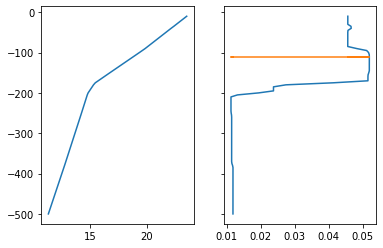

In [8]:
tmp_temp = upper_temp_AWG[11,:]

tmp_temp_grad = np.gradient(upper_temp_AWG,upper_pres,axis=1)[11,:]
TCP_ind = np.nanargmax(np.abs(tmp_temp_grad))

fig, (ax1,ax2) = plt.subplots(1,2,sharey = True)

ax1.plot(tmp_temp,-1*upper_pres)
ax2.plot(np.abs(tmp_temp_grad),-1*upper_pres)
ax2.plot(np.abs(tmp_temp_grad),-1*np.full(upper_pres.shape,upper_pres[TCP_ind]))
upper_pres[TCP_ind]

# <font color='darkblue'>Gradient Scatterplots</font> 

## <font color='orange'>Merged</font> 

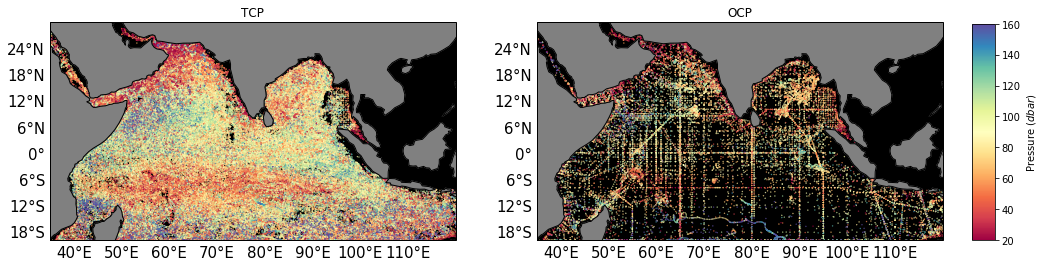

In [9]:
# # Plotting Full Indian Ocean

# limits 
cmin = 20
cmax = 160
sz = .5
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCP_AWG,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0],[35,120,-20,30])
axes[0].set_title('TCP')

p4 = axes[1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCP_AWG,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1],[35,120,-20,30])
axes[1].set_title('OCP')

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>WOA</font> 

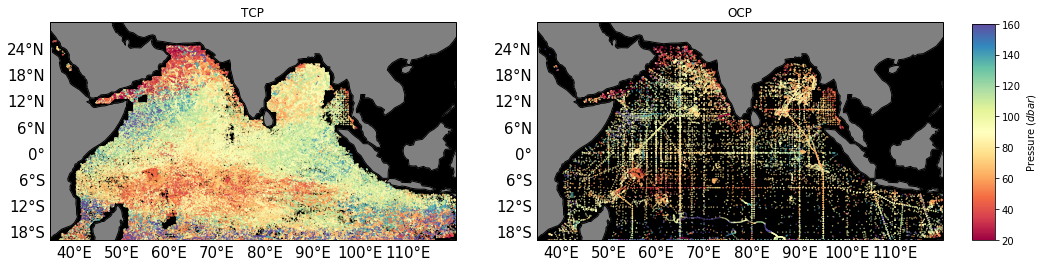

In [10]:
cmin = 20
cmax = 160
sz = .5
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCP_WOA,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0],[35,120,-20,30])
axes[0].set_title('TCP')

p4 = axes[1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCP_WOA,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1],[35,120,-20,30])
axes[1].set_title('OCP')

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')


## <font color='orange'>TCD Anomalies</font> 

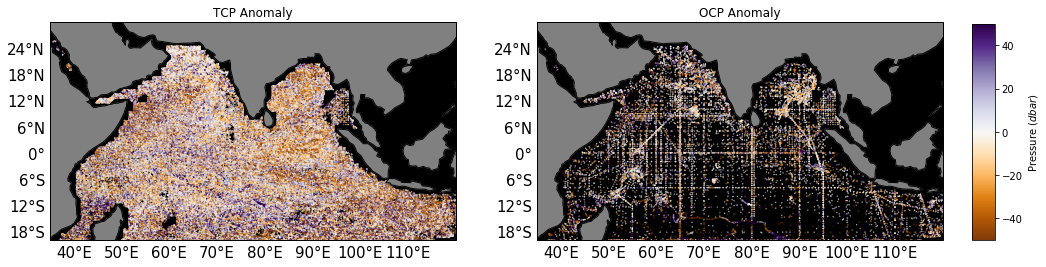

In [11]:
# limits 
cmin = -50
cmax = 50
sz = .5
cmap = plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCP_anom,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0],[35,120,-20,30])
axes[0].set_title('TCP Anomaly')

p4 = axes[1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCP_anom,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1],[35,120,-20,30])
axes[1].set_title('OCP Anomaly')

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# <font color='darkblue'>Binned Maps</font> 

https://stackoverflow.com/questions/40465026/groupby-bins-on-two-variables

## <font color='orange'>Merged</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: Mean of empty slice


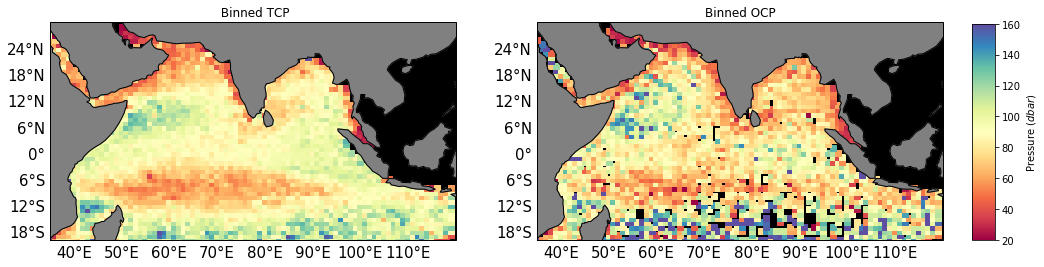

In [12]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCP_binned_ave_AWG,TCP_bincounts_AWG,latbins,lonbins = latlonbin(ds_CD.TCP_AWG,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCP_binned_ave_AWG,OCP_bincounts_AWG,_,_ = latlonbin(ds_CD.OCP_AWG,ds_CD.lat,ds_CD.lon,bounds,binwidth)

# add to dataset
ds_CD['TCP_binned_ave_AWG'] = xr.DataArray(TCP_binned_ave_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCP_binned_ave_AWG'] = xr.DataArray(OCP_binned_ave_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['TCP_bincounts_AWG'] = xr.DataArray(TCP_bincounts_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCP_bincounts_AWG'] = xr.DataArray(OCP_bincounts_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax =160
s = 20
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_CD.TCP_binned_ave_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0],[35,120,-20,30])
axes[0].set_title(' Binned TCP')

p3 = axes[1].scatter(xx,yy,c = ds_CD.OCP_binned_ave_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1],[35,120,-20,30])
axes[1].set_title('Binned OCP')

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>WOA</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: Mean of empty slice


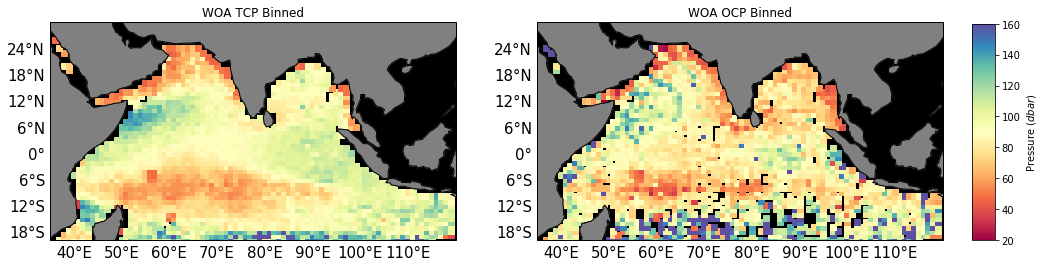

In [13]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCP_binned_ave_WOA, TCP_bincounts_WOA,latbins_WOA,lonbins_WOA = latlonbin(ds_CD.TCP_WOA,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCP_binned_ave_WOA, OCP_bincounts_WOA,_,_ = latlonbin(ds_CD.OCP_WOA,ds_CD.lat,ds_CD.lon,bounds,binwidth)

# add to dataset
ds_CD['TCP_binned_ave_WOA'] = xr.DataArray(TCP_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_CD['OCP_binned_ave_WOA'] = xr.DataArray(OCP_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_CD['TCP_bincounts_WOA'] = xr.DataArray(TCP_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_CD['OCP_bincounts_WOA'] = xr.DataArray(OCP_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])


xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax =160
s = 20
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_CD.TCP_binned_ave_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0],[35,120,-20,30])
axes[0].set_title('WOA TCP Binned')

p3 = axes[1].scatter(xx,yy,c = ds_CD.OCP_binned_ave_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1],[35,120,-20,30])
axes[1].set_title('WOA OCP Binned')

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>Anomaly</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: Mean of empty slice


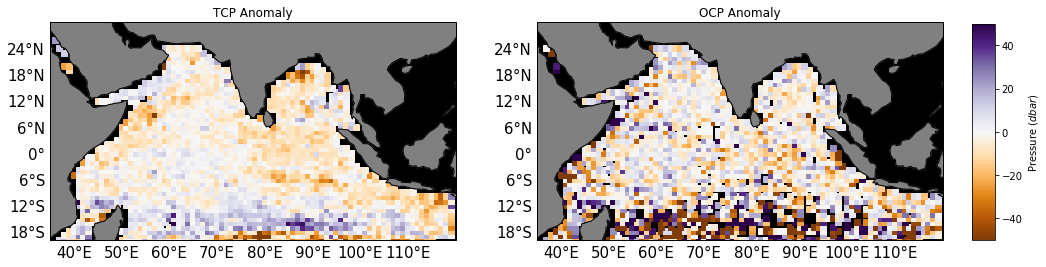

In [14]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCP_anom_binned_ave, TCP_anom_bincounts,latbins,lonbins = latlonbin(ds_CD.TCP_anom,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCP_anom_binned_ave, OCP_anom_bincounts,_,_ = latlonbin(ds_CD.OCP_anom,ds_CD.lat,ds_CD.lon,bounds,binwidth)
   
# add to dataset
ds_CD['TCP_anom_binned_ave'] = xr.DataArray(TCP_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCP_anom_binned_ave'] = xr.DataArray(OCP_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['TCP_anom_bincounts'] = xr.DataArray(TCP_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCP_anom_bincounts'] = xr.DataArray(OCP_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = -50
cmax = 50
s = 20
cmap = plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_CD.TCP_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0],[35,120,-20,30])
axes[0].set_title('TCP Anomaly')

p3 = axes[1].scatter(xx,yy,c = ds_CD.OCP_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1],[35,120,-20,30])
axes[1].set_title('OCP Anomaly')

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')



# Find Water Column Averages

In [15]:
# find mean temperature and doxy total water column
doxy_total_ave = np.nanmean(ds_CD.doxy_AWG,1)
temp_total_ave = np.nanmean(ds_CD.temp_AWG,1)
doxy_anom_total_ave = np.nanmean(ds_CD.doxy_anom,1)
temp_anom_total_ave = np.nanmean(ds_CD.temp_anom,1)
doxy_WOA_total_ave = np.nanmean(ds_CD.doxy_WOA,1)
temp_WOA_total_ave = np.nanmean(ds_CD.temp_WOA,1)

# find mean temperature and doxy 10-50dbar
ind = (ds_CD.pres>= 10) & (ds_CD.pres<= 50)
doxy_10_50_ave = np.nanmean(ds_CD.doxy_AWG[:,ind],1)
temp_10_50_ave = np.nanmean(ds_CD.temp_AWG[:,ind],1)
doxy_WOA_10_50_ave = np.nanmean(ds_CD.doxy_WOA[:,ind],1)
temp_WOA_10_50_ave = np.nanmean(ds_CD.temp_WOA[:,ind],1)
# doxy_anom_10_50_ave = doxy_10_50_ave - doxy_WOA_10_50_ave
# temp_anom_10_50_ave = temp_10_50_ave - temp_WOA_10_50_ave
doxy_anom_10_50_ave = np.nanmean(ds_CD.doxy_anom[:,ind],1)
temp_anom_10_50_ave = np.nanmean(ds_CD.temp_anom[:,ind],1)

# find mean temperature and doxy 50-200dbar
ind = (ds_CD.pres>= 50) & (ds_CD.pres<= 200)
doxy_50_200_ave = np.nanmean(ds_CD.doxy_AWG[:,ind],1)
temp_50_200_ave = np.nanmean(ds_CD.temp_AWG[:,ind],1)
doxy_WOA_50_200_ave = np.nanmean(ds_CD.doxy_WOA[:,ind],1)
temp_WOA_50_200_ave = np.nanmean(ds_CD.temp_WOA[:,ind],1)
# doxy_anom_50_200_ave = doxy_50_200_ave - doxy_WOA_50_200_ave 
# temp_anom_50_200_ave = temp_50_200_ave - temp_WOA_50_200_ave
doxy_anom_50_200_ave = np.nanmean(ds_CD.doxy_anom[:,ind],1)
temp_anom_50_200_ave = np.nanmean(ds_CD.temp_anom[:,ind],1)

# find mean temperature and doxy 50-500dbar
ind = (ds_CD.pres>= 50) & (ds_CD.pres<= 500)
doxy_50_500_ave = np.nanmean(ds_CD.doxy_AWG[:,ind],1)
temp_50_500_ave = np.nanmean(ds_CD.temp_AWG[:,ind],1)
doxy_WOA_50_500_ave = np.nanmean(ds_CD.doxy_WOA[:,ind],1)
temp_WOA_50_500_ave = np.nanmean(ds_CD.temp_WOA[:,ind],1)
# doxy_anom_50_500_ave = doxy_50_500_ave - doxy_WOA_50_500_ave 
# temp_anom_50_500_ave = temp_50_500_ave - temp_WOA_50_500_ave
doxy_anom_50_500_ave = np.nanmean(ds_CD.doxy_anom[:,ind],1)
temp_anom_50_500_ave = np.nanmean(ds_CD.temp_anom[:,ind],1)

# find mean temperature and doxy 10-200dbar
ind = (ds_CD.pres>= 10) & (ds_CD.pres<= 200)
doxy_10_200_ave = np.nanmean(ds_CD.doxy_AWG[:,ind],1)
temp_10_200_ave = np.nanmean(ds_CD.temp_AWG[:,ind],1)
doxy_WOA_10_200_ave = np.nanmean(ds_CD.doxy_WOA[:,ind],1)
temp_WOA_10_200_ave = np.nanmean(ds_CD.temp_WOA[:,ind],1)
# doxy_anom_10_200_ave = doxy_10_200_ave - doxy_WOA_10_200_ave
# temp_anom_10_200_ave = temp_10_200_ave - temp_WOA_10_200_ave
doxy_anom_10_200_ave = np.nanmean(ds_CD.doxy_anom[:,ind],1)
temp_anom_10_200_ave = np.nanmean(ds_CD.temp_anom[:,ind],1)

# find mean temperature and doxy 100-200dbar
ind = (ds_CD.pres>= 100) & (ds_CD.pres<= 200)
doxy_100_200_ave = np.nanmean(ds_CD.doxy_AWG[:,ind],1)
temp_100_200_ave = np.nanmean(ds_CD.temp_AWG[:,ind],1)
doxy_WOA_100_200_ave = np.nanmean(ds_CD.doxy_WOA[:,ind],1)
temp_WOA_100_200_ave = np.nanmean(ds_CD.temp_WOA[:,ind],1)
# doxy_anom_100_200_ave = doxy_100_200_ave - doxy_WOA_100_200_ave
# temp_anom_100_200_ave = temp_100_200_ave - temp_WOA_100_200_ave
doxy_anom_100_200_ave = np.nanmean(ds_CD.doxy_anom[:,ind],1)
temp_anom_100_200_ave = np.nanmean(ds_CD.temp_anom[:,ind],1)

# find mean temperature and doxy below my estimated TCD
doxy_TCP_bot_ave = np.zeros(ds_CD.TCP_AWG.shape)*np.nan
temp_TCP_bot_ave = np.zeros(ds_CD.TCP_AWG.shape)*np.nan
doxy_anom_TCP_bot_ave = np.zeros(ds_CD.TCP_AWG.shape)*np.nan
temp_anom_TCP_bot_ave = np.zeros(ds_CD.TCP_AWG.shape)*np.nan
doxy_WOA_TCP_bot_ave = np.zeros(ds_CD.TCP_WOA.shape)*np.nan
temp_WOA_TCP_bot_ave = np.zeros(ds_CD.TCP_WOA.shape)*np.nan

doxy_TCP_200_ave = np.zeros(ds_CD.TCP_AWG.shape)*np.nan
temp_TCP_200_ave = np.zeros(ds_CD.TCP_AWG.shape)*np.nan
doxy_anom_TCP_200_ave = np.zeros(ds_CD.TCP_AWG.shape)*np.nan
temp_anom_TCP_200_ave = np.zeros(ds_CD.TCP_AWG.shape)*np.nan
doxy_WOA_TCP_200_ave = np.zeros(ds_CD.TCP_WOA.shape)*np.nan
temp_WOA_TCP_200_ave = np.zeros(ds_CD.TCP_WOA.shape)*np.nan

for pr in tqdm(range(ds_CD.TCP_AWG.shape[0])):
    
    TCPtmp = np.array(ds_CD.TCP_AWG[pr])
    
    if ~np.isnan(TCPtmp):
        ind = (ds_CD.pres>= TCPtmp) & (ds_CD.pres<= 200)
        temp_TCP_200_ave[pr] = np.nanmean(ds_CD.temp_AWG[pr,ind])
        doxy_TCP_200_ave[pr] = np.nanmean(ds_CD.doxy_AWG[pr,ind])
        temp_anom_TCP_200_ave[pr] = np.nanmean(ds_CD.temp_anom[pr,ind])
        doxy_anom_TCP_200_ave[pr] = np.nanmean(ds_CD.doxy_anom[pr,ind])
        
        ind = (ds_CD.pres>= TCPtmp)
        temp_TCP_bot_ave[pr] = np.nanmean(ds_CD.temp_AWG[pr,ind])
        doxy_TCP_bot_ave[pr] = np.nanmean(ds_CD.doxy_AWG[pr,ind])
        temp_anom_TCP_bot_ave[pr] = np.nanmean(ds_CD.temp_anom[pr,ind])
        doxy_anom_TCP_bot_ave[pr] = np.nanmean(ds_CD.doxy_anom[pr,ind])
   
    TCPtmp = np.array(ds_CD.TCP_WOA[pr])
    
    if ~np.isnan(TCPtmp):
        ind = (ds_CD.pres>= TCPtmp) & (ds_CD.pres<= 200)
        temp_WOA_TCP_200_ave[pr] = np.nanmean(ds_CD.temp_WOA[pr,ind])
        doxy_WOA_TCP_200_ave[pr] = np.nanmean(ds_CD.doxy_WOA[pr,ind])
        
        ind = (ds_CD.pres>= TCPtmp)
        temp_WOA_TCP_bot_ave[pr] = np.nanmean(ds_CD.temp_WOA[pr,ind])
        doxy_WOA_TCP_bot_ave[pr] = np.nanmean(ds_CD.doxy_WOA[pr,ind])

        
# add to dataset
ds_CD['temp_total_ave'] = xr.DataArray(temp_total_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_total_ave'] = xr.DataArray(doxy_total_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_10_200_ave'] = xr.DataArray(temp_10_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_10_200_ave'] = xr.DataArray(doxy_10_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_10_50_ave'] = xr.DataArray(temp_10_50_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_10_50_ave'] = xr.DataArray(doxy_10_50_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_50_200_ave'] = xr.DataArray(temp_50_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_50_200_ave'] = xr.DataArray(doxy_50_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_50_500_ave'] = xr.DataArray(temp_50_500_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_50_500_ave'] = xr.DataArray(doxy_50_500_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_100_200_ave'] = xr.DataArray(temp_100_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_100_200_ave'] = xr.DataArray(doxy_100_200_ave,dims = ['time'],coords =[ds_CD.time])

ds_CD['temp_anom_total_ave'] = xr.DataArray(temp_anom_total_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_anom_total_ave'] = xr.DataArray(doxy_anom_total_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_anom_10_200_ave'] = xr.DataArray(temp_anom_10_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_anom_10_200_ave'] = xr.DataArray(doxy_anom_10_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_anom_10_50_ave'] = xr.DataArray(temp_anom_10_50_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_anom_10_50_ave'] = xr.DataArray(doxy_anom_10_50_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_anom_50_200_ave'] = xr.DataArray(temp_anom_50_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_anom_50_200_ave'] = xr.DataArray(doxy_anom_50_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_anom_50_500_ave'] = xr.DataArray(temp_anom_50_500_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_anom_50_500_ave'] = xr.DataArray(doxy_anom_50_500_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_anom_100_200_ave'] = xr.DataArray(temp_anom_100_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_anom_100_200_ave'] = xr.DataArray(doxy_anom_100_200_ave,dims = ['time'],coords =[ds_CD.time])

ds_CD['temp_WOA_total_ave'] = xr.DataArray(temp_WOA_total_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_WOA_total_ave'] = xr.DataArray(doxy_WOA_total_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_WOA_10_200_ave'] = xr.DataArray(temp_WOA_10_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_WOA_10_200_ave'] = xr.DataArray(doxy_WOA_10_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_WOA_10_50_ave'] = xr.DataArray(temp_WOA_10_50_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_WOA_10_50_ave'] = xr.DataArray(doxy_WOA_10_50_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_WOA_50_200_ave'] = xr.DataArray(temp_WOA_50_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_WOA_50_200_ave'] = xr.DataArray(doxy_WOA_50_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_WOA_50_500_ave'] = xr.DataArray(temp_WOA_50_500_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_WOA_50_500_ave'] = xr.DataArray(doxy_WOA_50_500_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_WOA_100_200_ave'] = xr.DataArray(temp_WOA_100_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_WOA_100_200_ave'] = xr.DataArray(doxy_WOA_100_200_ave,dims = ['time'],coords =[ds_CD.time])

ds_CD['temp_TCP_bot_ave'] = xr.DataArray(temp_TCP_bot_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_TCP_bot_ave'] = xr.DataArray(doxy_TCP_bot_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_TCP_200_ave'] = xr.DataArray(temp_TCP_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_TCP_200_ave'] = xr.DataArray(doxy_TCP_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_anom_TCP_bot_ave'] = xr.DataArray(temp_anom_TCP_bot_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_anom_TCP_bot_ave'] = xr.DataArray(doxy_anom_TCP_bot_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_anom_TCP_200_ave'] = xr.DataArray(temp_anom_TCP_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_anom_TCP_200_ave'] = xr.DataArray(doxy_anom_TCP_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_WOA_TCP_bot_ave'] = xr.DataArray(temp_WOA_TCP_bot_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_WOA_TCP_bot_ave'] = xr.DataArray(doxy_WOA_TCP_bot_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['temp_WOA_TCP_200_ave'] = xr.DataArray(temp_WOA_TCP_200_ave,dims = ['time'],coords =[ds_CD.time])
ds_CD['doxy_WOA_TCP_200_ave'] = xr.DataArray(doxy_WOA_TCP_200_ave,dims = ['time'],coords =[ds_CD.time])

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/jenn

In [16]:
# find coastal masks of data

mask = mask_coast(np.array(ds_CD.lon),np.array(ds_CD.lat),[35,120,-5,30])

ds_CD['temp_TCP_200_ave_coast'] = xr.DataArray(ds_CD.temp_TCP_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_TCP_200_ave_coast'] = xr.DataArray(ds_CD.doxy_TCP_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_WOA_TCP_200_ave_coast'] = xr.DataArray(ds_CD.temp_WOA_TCP_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_WOA_TCP_200_ave_coast'] = xr.DataArray(ds_CD.doxy_WOA_TCP_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_anom_TCP_200_ave_coast'] = xr.DataArray(ds_CD.temp_anom_TCP_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_anom_TCP_200_ave_coast'] = xr.DataArray(ds_CD.doxy_anom_TCP_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])

ds_CD['temp_10_200_ave_coast'] = xr.DataArray(ds_CD.temp_10_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_10_200_ave_coast'] = xr.DataArray(ds_CD.doxy_10_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_WOA_10_200_ave_coast'] = xr.DataArray(ds_CD.temp_WOA_10_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_WOA_10_200_ave_coast'] = xr.DataArray(ds_CD.doxy_WOA_10_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_anom_10_200_ave_coast'] = xr.DataArray(ds_CD.temp_anom_10_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_anom_10_200_ave_coast'] = xr.DataArray(ds_CD.doxy_anom_10_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])

ds_CD['temp_10_50_ave_coast'] = xr.DataArray(ds_CD.temp_10_50_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_10_50_ave_coast'] = xr.DataArray(ds_CD.doxy_10_50_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_WOA_10_50_ave_coast'] = xr.DataArray(ds_CD.temp_WOA_10_50_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_WOA_10_50_ave_coast'] = xr.DataArray(ds_CD.doxy_WOA_10_50_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_anom_10_50_ave_coast'] = xr.DataArray(ds_CD.temp_anom_10_50_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_anom_10_50_ave_coast'] = xr.DataArray(ds_CD.doxy_anom_10_50_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])

ds_CD['temp_50_200_ave_coast'] = xr.DataArray(ds_CD.temp_50_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_50_200_ave_coast'] = xr.DataArray(ds_CD.doxy_50_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_WOA_50_200_ave_coast'] = xr.DataArray(ds_CD.temp_WOA_50_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_WOA_50_200_ave_coast'] = xr.DataArray(ds_CD.doxy_WOA_50_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_anom_50_200_ave_coast'] = xr.DataArray(ds_CD.temp_anom_50_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_anom_50_200_ave_coast'] = xr.DataArray(ds_CD.doxy_anom_50_200_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])

ds_CD['temp_50_500_ave_coast'] = xr.DataArray(ds_CD.temp_50_500_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_50_500_ave_coast'] = xr.DataArray(ds_CD.doxy_50_500_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_WOA_50_500_ave_coast'] = xr.DataArray(ds_CD.temp_WOA_50_500_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_WOA_50_500_ave_coast'] = xr.DataArray(ds_CD.doxy_WOA_50_500_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_anom_50_500_ave_coast'] = xr.DataArray(ds_CD.temp_anom_50_500_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_anom_50_500_ave_coast'] = xr.DataArray(ds_CD.doxy_anom_50_500_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])


ds_CD['temp_TCP_bot_ave_coast'] = xr.DataArray(ds_CD.temp_TCP_bot_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_TCP_bot_ave_coast'] = xr.DataArray(ds_CD.doxy_TCP_bot_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_WOA_TCP_bot_ave_coast'] = xr.DataArray(ds_CD.temp_WOA_TCP_bot_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_WOA_TCP_bot_ave_coast'] = xr.DataArray(ds_CD.doxy_WOA_TCP_bot_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_anom_TCP_bot_ave_coast'] = xr.DataArray(ds_CD.temp_anom_TCP_bot_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_anom_TCP_bot_ave_coast'] = xr.DataArray(ds_CD.doxy_anom_TCP_bot_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])

ds_CD['temp_total_ave_coast'] = xr.DataArray(ds_CD.temp_total_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_total_ave_coast'] = xr.DataArray(ds_CD.doxy_total_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_WOA_total_ave_coast'] = xr.DataArray(ds_CD.temp_WOA_total_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_WOA_total_ave_coast'] = xr.DataArray(ds_CD.doxy_WOA_total_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['temp_anom_total_ave_coast'] = xr.DataArray(ds_CD.temp_anom_total_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['doxy_anom_total_ave_coast'] = xr.DataArray(ds_CD.doxy_anom_total_ave[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])

ds_CD['lon_coast'] = xr.DataArray(ds_CD.lon[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])
ds_CD['lat_coast'] = xr.DataArray(ds_CD.lat[mask],dims = ['coast_time'],coords =[ds_CD.time[mask]])


In [17]:
import os

outfn = '../data/CD/awg_cd.nc'

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_CD.to_netcdf(outfn,mode='w',format = "NETCDF4")
# ds_CD

In [18]:
ds_CD.time

<xarray.DataArray 'time' (time: 306118)>
array(['1827-10-30T00:00:00.000000000', '1836-05-15T00:00:00.000000000',
       '1838-12-20T00:00:00.000000000', ..., '2020-02-07T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000', '2020-02-07T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    prof     (time) int32 ...
  * time     (time) datetime64[ns] 1827-10-30 1836-05-15 ... 2020-02-07